# 95-865 Homework 3

Your name: Kaumudi Vuppala

Your Andrew ID: kvuppala

Collaborators (if none, say \"none\"; do *not* leave this blank): Sagnik, Priyanka, Shubham 

# Part 1: Email spam classification [50 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

### (a) Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it?

In [1]:
#your code here
import glob
ham_emails = []
spam_emails = []
for filename in glob.glob('./email-data/ham/*.txt'):
    ham_emails.append(filename)

for filename in glob.glob('./email-data/spam/*.txt'):
    spam_emails.append(filename)
    
print('Length of business emails in training data ',len(ham_emails))
print('Length of spam emails in training data ',len(spam_emails))

Length of business emails in training data  1500
Length of spam emails in training data  3671


***Yes, the dataset is imbalanced. We have 1500 ham emails and 3671 spam emails. It will be problematic because, the model tends to learn correct for spam emails i.e it will have higher accuracy when predicting the spam emails when compared to not spam emails. In this usecase, if the model cannot classify the actual business mails correctly, then they are wrongly classified as spam and we will loose all the important emails. Hence, its really important to train the model correctly. 
To address this problem, instead of accuracy, we can use various measures like precision, and recall by building the confusion matrix. And the other methods to balance the data would be to use some sampling techniques to balance our data like undersampling,oversampling, and SMOTE etc.***

### (b) Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [2]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
#your code here
content = []
labels = []
for p in ham_emails:
    a = makeWordList(p)
    content.append(a)
    labels.append(0)

for p in spam_emails:        
    b = makeWordList(p)
    content.append(b)
    labels.append(1)

#for test data to test our models later
path3= glob.glob('./email-data/testing/*.txt')
test_content = []
test_labels = []
for p in path3:
    c = makeWordList(p)
    test_content.append(c)
    if 'ham' in p:
        test_labels.append(0)
    if 'spam' in p:
        test_labels.append(1)

In [4]:
print(len(labels))
print(len(content))
print(len(test_content))
print(len(test_labels))

5171
5171
100
100


### (c) Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [5]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=50,stop_words="english",max_df=0.8)
X = vectorizer.fit_transform(content)
vocab =vectorizer.vocabulary_
print('size of the vocabulary ',len(vocab))

size of the vocabulary  1680


In [6]:
#transforming test data
X1 = vectorizer.transform(test_content)

In [7]:
print(X.shape)
X1.shape

(5171, 1680)


(100, 1680)

### (d) k-NN, SVM, random forest: Hyperparameter selection [20 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.
   - Random forest: Select `n_estimators` **and** `max_depth` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_alpha` and `best_C` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import f1_score

lowest_cross_val_error = np.inf

num_folds = 5
k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
hyperparameter_settings = [k for k in range(1,21)]  # fill this with hyperparameter settings that you want to try
num_train_images = len(X.toarray())
indices = range(num_train_images)
best_k = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
flattened_train_data = X.toarray()

for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    for train_indices, val_indices in k_fold.split(indices):
        classifier = KNeighborsClassifier(n_neighbors=hyperparam_setting)
        classifier.fit(flattened_train_data[train_indices],np.array(labels)[train_indices])
        predicted_val_labels = classifier.predict(flattened_train_data[val_indices])
        f1_score_weighted = f1_score(np.array(labels)[val_indices], predicted_val_labels, average='weighted')
        fold_scores.append(f1_score_weighted)
        
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_k = hyperparam_setting

print('Best hyperparameter setting:', best_k,'best f1 score:',best_cross_val_score)

Best hyperparameter setting: 1 best f1 score: 0.9461699830922095


In [9]:
from sklearn import svm
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import f1_score
Cs = np.logspace(-4, 2, 10) #10 numbers evenly spaced between 10^-4 and 10^(2)
#Gammas = [1.0, 10.0, 100.0, 1000.0]
hyperparameter_settings = [C for C in Cs]

num_folds = 5
k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
best_hyperparam_setting = None
best_C = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
num_train_images = len(X.toarray())
indices = range(num_train_images)
flattened_train_data = X.toarray()
y_train = np.array(labels)

for hyperparam_setting in hyperparameter_settings:
    C = hyperparam_setting
    fold_scores = []
    for k, (train_indices, val_indices) in enumerate(k_fold.split(flattened_train_data, y_train)):
        classifier = svm.SVC(kernel='rbf', gamma='auto', C=C)
        classifier.fit(flattened_train_data[train_indices],y_train[train_indices])
        y_pred = classifier.predict(flattened_train_data[val_indices])
        y_val = np.array(labels)[val_indices]
        f1_score_weighted = f1_score(y_val, y_pred, average='weighted')
        fold_scores.append(f1_score_weighted)
        
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_C = hyperparam_setting

print('Best hyperparameter setting:', best_C,'best f1 score:',best_cross_val_score)

Best hyperparameter setting: 100.0 best f1 score: 0.9856251806458303


In [11]:
from sklearn.ensemble import RandomForestClassifier

hyperparameter_settings = [(num_trees, max_depth)
                           for num_trees in [50, 100, 150, 200]
                           for max_depth in [3, 4, 5, None]]  # fill this with hyperparameter settings that you want to try
#indices = range(num_train_images)
best_hyperparam_setting = None
best_num_trees = None
best_depth = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    num_trees, max_depth = hyperparam_setting
    fold_scores = []
    # your code to train and score the training data here
    for train_indices, val_indices in k_fold.split(indices):
        classifier = RandomForestClassifier(n_estimators=num_trees,
                                            max_depth=max_depth,
                                            random_state=0)
        classifier.fit(flattened_train_data[train_indices],np.array(labels)[train_indices])
        predicted_val_labels = classifier.predict(flattened_train_data[val_indices])
        f1_score_weighted = f1_score(np.array(labels)[val_indices], predicted_val_labels, average='weighted')
        fold_scores.append(f1_score_weighted)
        
    cross_val_score = np.mean(fold_scores)
    
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_num_trees, best_depth = hyperparam_setting

print('Best hyperparameter setting:', best_num_trees, best_depth,'f_Score:',best_cross_val_score)

Best hyperparameter setting: 200 None f_Score: 0.9887540689332248


### (e) Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

***Some words in test data may not be there in training data. When using count vectorizer, we transform the test data only based on training data, thus we might incur new words which train data did not have. One approch to over come this issue is, we can go back and retrain our model by putting the new words in training model. Also, we can make our training data better so that we will not have such issues during test time.***

In [12]:
#test data
X_test = X1.toarray()
X_test.shape

(100, 1680)

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

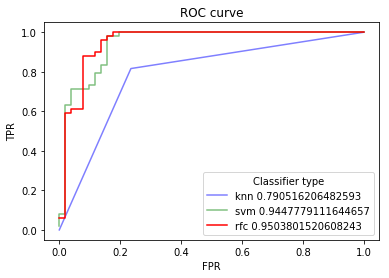

In [16]:
#your code here
#fitting the classifiers with the best hyperparameter
#roc curve
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# flattened_train_data = X.toarray()
# y_train = np.array(labels)

colors = ["b", "g", 'r']
best_k = 1
# best_C = 4.641588833612772 
# #best_gamma = 1.0
# best_num_trees = 200
# best_depth = None
#knn classifier
clf_knn = KNeighborsClassifier(n_neighbors=best_k)
clf_knn.fit(flattened_train_data,np.array(labels))
predictedKNN = clf_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(np.array(test_labels), predictedKNN, pos_label=1)
auc = np.trapz(tpr, fpr)
l1 = 'knn '+auc.astype(str)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= colors[0], label = l1)

#svm classifier
clf_svm = svm.SVC(kernel='rbf', gamma='auto', C=best_C)
clf_svm.fit(flattened_train_data, np.array(labels))
predictedSVM = clf_svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(np.array(test_labels), predictedSVM,pos_label=1)
auc = np.trapz(tpr, fpr)
l2 = 'svm '+auc.astype(str)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= colors[1], label = l2)


#random forest classifier
clf_rfc = RandomForestClassifier(n_estimators=best_num_trees,
                                            max_depth=best_depth,
                                            random_state=0)
clf_rfc.fit(flattened_train_data, np.array(labels))
predictedRFC= clf_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(np.array(test_labels), predictedRFC,pos_label=1)
auc = np.trapz(tpr, fpr)
l3 = 'rfc '+auc.astype(str)
plt.plot(fpr, tpr, linestyle='-', color= colors[2], label = l3)

plt.legend(title = 'Classifier type', loc = 'best')   
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

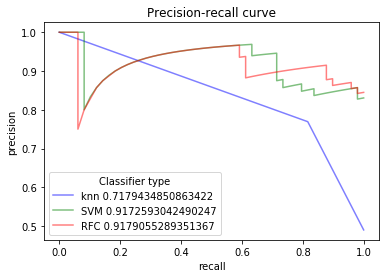

In [17]:
#precision_recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(np.array(test_labels), predictedKNN, pos_label=1)
average_precision = average_precision_score(np.array(test_labels), predictedKNN)
p1 = 'knn '+average_precision.astype(str)
plt.plot(recall, precision, linestyle='-', alpha=0.5, color= colors[0], label = p1)



precision2, recall2, _ = precision_recall_curve(np.array(test_labels), predictedSVM, pos_label=1)
average_precision2 = average_precision_score(np.array(test_labels), predictedSVM)
p2 = 'SVM '+average_precision2.astype(str)
plt.plot(recall2, precision2, linestyle='-', alpha=0.5, color= colors[1], label = p2)

precision3, recall3, _ = precision_recall_curve(np.array(test_labels), predictedRFC, pos_label=1)
average_precision3 = average_precision_score(np.array(test_labels), predictedRFC)
p3 = 'RFC '+average_precision3.astype(str)
plt.plot(recall3, precision3, linestyle='-', alpha=0.5, color= colors[2], label = p3)


plt.legend(title = 'Classifier type', loc = 'best')   
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()


**Things to answer:**

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   
       ***In this case, we do not want to misclassify not spam mails as spam more than the other way around i.e classifying spam as business email. For this case, I choose precision-recall curve because our positive samples are less than the negative ones. So precision-recall curves will help us to choose better classifier compared to ROC curve.***
       
   - Which classifier is the best, according to your chosen curves?
   
   ***Random forest has better precision score comparitively to other classifiers, and also the area under the curve for random forest is higher than others. So , I would choose Random Forest to classify my instances.***
  

# Part 2: Image Segmentation [50 points]

### What is segmentation?

Segmentation is the task of "labeling" groups of pixels in an image to identify certain objects.

In the early years, research on segmentation was focused on "foreground-background" segmentation; marking only those pixels that comprise the "background" of an image (in the image below, the background is marked in blue).

<div>
<img src="http://www.eyeshalfclosed.com/images/cat.jpg" width=500/>
</div>

In recent years, sophisticated deep-learning models have enabled complex multi-label segmentation, such as in the images below.

<tr>
<td>
<img src="http://www.eyeshalfclosed.com/images/sheep.png" width=500/>
</td>
<td>
<img src="http://www.eyeshalfclosed.com/images/street.png" width=500/>
</td>
</tr>
   

### (a) Prerequisites [20 points]

You get 20 points for setting up AWS and successfully running the code given in the following sections.

This homework needs to be run on an AWS GPU instance; it will not complete in time without a GPU. Look up the relevant documentation to set up an AWS machine as configured below.

**Machine.**

   - Use the [Ubuntu Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B077GCH38C).
   - Use a p2.xlarge instance.
   - Allocate at least 80GB of disk space.
   - Use the `conda_tensorflow_p36` Conda environment: `source activate tensorflow_p36`
   - Create a security group and open all inbound/outbound ports to 0.0.0.0/0.

All commands below assume the aforementioned Conda environment is active.

**Run Jupyter.** `jupyter notebook --ip=* --no-browser`

You may move Jupyter to the background by: CTRL-Z, then `bg`, then `disown`. You can access Jupyter using your public DNS; it will look something like `ec2-54-84-36-171.compute-1.amazonaws.com:8888`. Figure out how you can find this out.

**Data downloads.** All downloads must go into the same directory as this notebook. Unzip files after download. *This will take time.*

   * Download the [trained model weights](https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5) (~250MB).

   * Download the [training images](http://images.cocodataset.org/zips/train2014.zip) (13GB).
   
   * Download the [validation images](http://images.cocodataset.org/zips/val2014.zip) (6GB).
   * Download the [training image annotations](https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0).
   * Download the [test image annotations](https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0).

Now create a new folder named `2014`, then move the `train2014`, `val2014` folders into `2014/`.

Create a new `2014/annotations/` folder and move the train and test annotation JSON files into it

Your directory structure should look like:
```
2014/
   /annotations/
       /annotations/instances_minival2014.json
       /annotations/instances_valminusminival2014.json
   /train2014/
       /train2014/*.jpg
   /val2014/
       /val2014/*.jpg
```

**Package installation.**

   * Install Cython: `pip install cython`
   * Install Tensorflow: `pip install tensorflow tensorflow-gpu`
   * Install Keras and image tools: `pip install keras scikit-image pillow h5py`
   * Install OpenCV: `pip install opencv-python`
   * Install pycoco:
   
`pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"`
   
**GPU.** Ensure Keras/TensorFlow can see your GPU with the following Python code (run in the `conda_tensorflow_p36 environment` after installing all the required packages). You should see a GPU in one of the devices listed.

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16729841330120563854
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10495963794639718122
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16638309582799926093
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281927373
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14065236956781021903
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Testing a pre-trained model on small data

We will first load a pre-trained convolutional neural network model and test it on a small dataset of images. These images are stored in the `/images/` folder.

The model was trained by annotating each image with the objects it contains. Annotations are in the following format:

```
annotation{
    "id" : int,
    "image_id" : int,
    "category_id" : int,
    "segmentation" : RLE or [polygon],
    "area" : float,
    "bbox" : [x,y,width,height],
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int,
    "name" : str,
    "supercategory" : str,
}]
```

Make sure you understand the annotations and how they are connect to images by looking at [section 4 on this page](http://cocodataset.org/#download). You may ignore the `iscrowd` variable.

### Set up the environment

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fil

### Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

### Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [4]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 9.23 s, sys: 652 ms, total: 9.88 s
Wall time: 9.74 s


### Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Load and visualize a random image

Make sure you understand what the code below is doing.

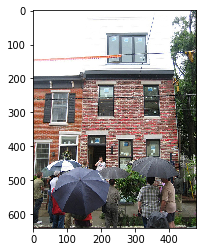

In [6]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

### Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

Processing 1 images
image                    shape: (640, 480, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
CPU times: user 7.7 s, sys: 2.57 s, total: 10.3 s
Wall time: 10.3 s


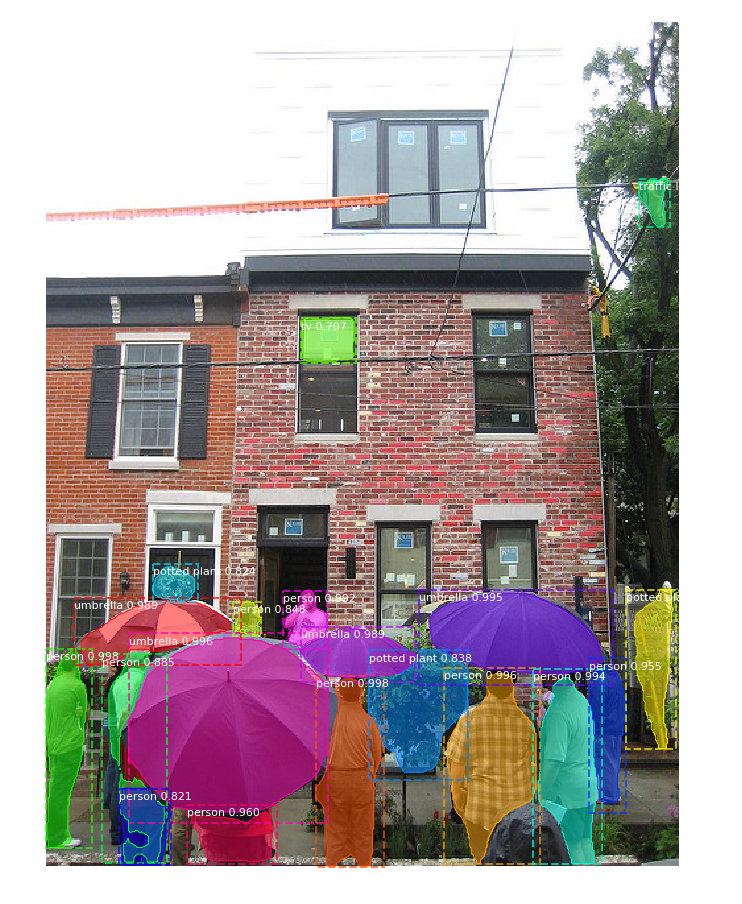

In [7]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

### Load the data

Load the annotations for the training images into memory.

In [8]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
CPU times: user 672 ms, sys: 52 ms, total: 724 ms
Wall time: 718 ms


Now load the same for the test images.

In [9]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

loading annotations into memory...
Done (t=4.59s)
creating index...
index created!
CPU times: user 5.12 s, sys: 364 ms, total: 5.48 s
Wall time: 5.46 s


### List a few object classes

In [10]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

Image Count: 4952
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      


### Visualize a random image and its annotations

image_id  4177 http://cocodataset.org/#explore?id=318238
image                    shape: (640, 478, 3)         min:    0.00000  max:  255.00000
mask                     shape: (640, 478, 4)         min:    0.00000  max:    1.00000
class_ids                shape: (4,)                  min:   16.00000  max:   60.00000
bbox                     shape: (4, 4)                min:    0.00000  max:  633.00000


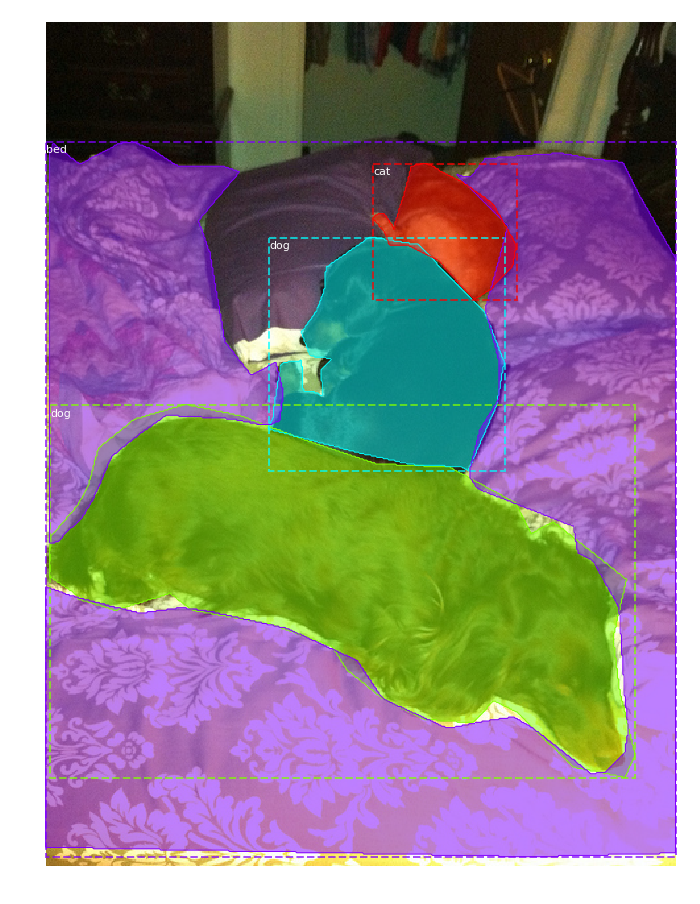

In [11]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Training configuration

See the default configuration values in `config.py`.

In [12]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING     

### (b) Create a new model in training mode [5 points]

In [13]:
# your code here
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

### (c) Initialize the model weights with the weights learned on COCO [5 points]

Call `load_weights` as before, but add the following argument in the call to the function:

```
exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"]
```

In [14]:
# your code here
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"])

### (d) Train the model for 10 epochs [5 points]

Look up the documentation or code for the train function to figure out its arguments.

Pass the following additional arguments to the `train` function:

   - `layers="heads"` to only train the weights that were not pre-loaded.
   - `learning_rate=config.LEARNING_RATE` to set the learning rate.
   - `epochs=10`.
   
This will take ~10 minutes on a p2.xlarge GPU instance with 1 GPU.

In [15]:
%%time
# call to train

model.train(dataset, dataset_val, learning_rate=config.LEARNING_RATE, epochs=10, layers="heads")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/HW3/logs/coco20190302T0111/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
60/60 [==============================] - 70s 1s/step - loss: 3.3467 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.3167 - mrcnn_class_loss: 1.4242 - mrcnn_bbox_loss: 0.8432 - mrcnn_mask_loss: 0.7412 - val_loss: 2.1056 - val_rpn_class_loss: 0.0280 - val_rpn_bbox_loss: 0.4828 - val_mrcnn_class_loss: 0.6822 - val_mrcnn_bbox_loss: 0.4509 - val_mrcnn_mask_loss: 0.4618
Epoch 2/10
60/60 [==============================] - 52s 874ms/step - loss: 2.2349 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3205 - mrcnn_class_loss: 0.7388 - mrcnn_bbox_loss: 0.5858 - mrcnn_mask_loss: 0.5793 - val_loss: 2.1459 - val_rpn_class_loss: 0.0292 - val_rpn_bbox_loss: 0.5961 - val_mrcnn_class_loss: 0.5997 - val_mrcnn_bbox_loss: 0.4955 - val_mrcnn_mask_loss: 0.4254
Epoch 3/10
60/60 [==============================] - 53s 878ms/step - loss: 2.3211 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.4002 - mrcnn_class_loss: 0.8206 - mrcnn_bbox_loss: 0.5409 - mrcnn_mask_loss: 0.5315 - val_loss: 2.0248 - val_rpn_class_loss

### (e) Visualize learning progress with TensorBoard [5 points]

   - Start Tensorboard (in a terminal) with `tensorboard --logdir=logs/` in the same folder as the notebook:
```
TensorBoard 0.1.8 at http://ip-172-31-27-18:6006 (Press CTRL+C to quit)
```

   - Connect to (in a web browser) `public_dns:6006` where `public_dns` is your public DNS (this is the address of your AWS machine).
   - Click on the "Scalars" tab at the top of the page.
   - Include a screenshot of the overall loss vs. number of epochs below this line (store the image in the same folder as the notebook as "yourloss.png"). **Important: When you submit your HW3, it should include `yourloss.png`.**
   
 <img src="yourloss.png"/>

### (f) Test model [10 points]

Load the model in inference (testing) mode.

In [19]:
# load model
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Load the last trained model weights.

In [20]:
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000
image_meta               shape: (89,)                 min:    0.00000  max: 20544.00000
gt_class_id              shape: (13, 4)               min:    0.00000  max: 1024.00000
gt_bbox                  shape: (13, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 13)      min:    0.00000  max:    1.00000


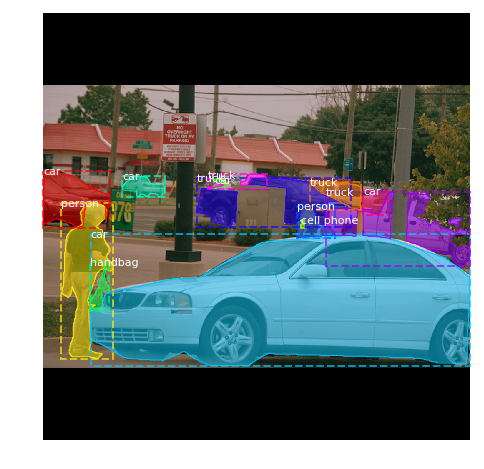

In [21]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


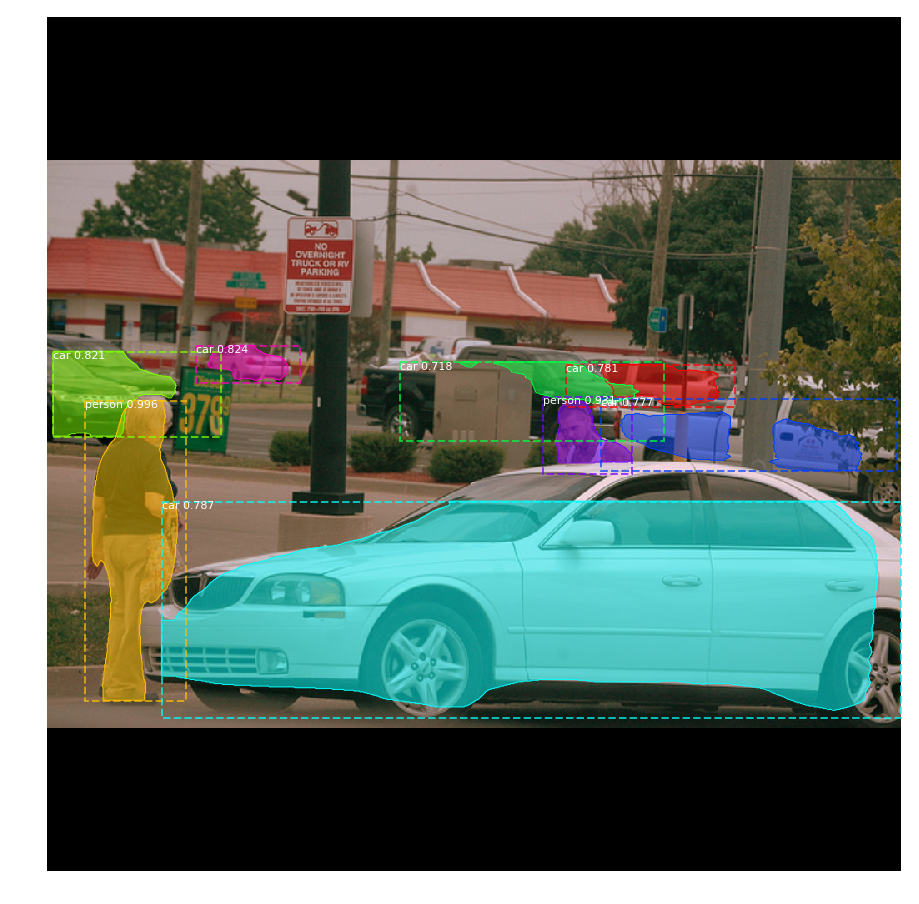

In [22]:
# prediction function call and visualization
results = model.detect([original_image],verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Part 3: Sentiment Analysis [50 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- train.csv
- test.csv

### (a) Read the training data  [5 Points]

Read the data present in train.csv file. **Please do no change the file name. In particular, use a relative path, i.e., './HW3-data/train.csv'** <br>
Perform the following cleaning on the data:
1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Shuffle the rows of the data frame such that the positive and negative tweets are mixed
3. Print the first 5 sentiments.
4. Print the number of positive and negative sentiment labels
Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [1]:
# your code here
import pandas as pd
df= pd.read_csv("./HW3-data/train.csv",encoding = "ISO-8859-1",header=None)
df_sentiments = df[[0,5]]
df_sentiments = df_sentiments.sample(frac=1).reset_index(drop=True)
print(df_sentiments.head())
df_sentiments[0].value_counts()

   0                                                  5
0  1  waiting 4 my coffee 2 brew what would i do w/o...
1  1  meet me at the rainbow's end, where we dont ev...
2  0  best friend left me for texas  which means i'm...
3  0  i really miss him!!!!!!!!! i wanna spend some ...
4  0  @Eiwen sorry you can't sleep... I'm at a frien...


1    800000
0    800000
Name: 0, dtype: int64

### (b) Data Preparation [7 points]

Before building a neural network model, we first need to prepare the data. The input to a RNN model  is a matrix with shape (a, b), where a is the number of samples (tweets), and b is the sequence length of each tweet. Prepare the data with the following steps:

1\. Take the RAW texts of the top 5000 tweets in the data and convert them to a list of strings, where each string is a tweet. [1 pt]

In [2]:
# your code here
lst = df_sentiments[5].head(5000).tolist()
len(lst)

5000

2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with the `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [3]:
# your code here
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(lst)
train_data = tokenizer.texts_to_sequences(lst)

Using TensorFlow backend.


3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [4]:
# your code here
from keras.preprocessing import sequence
x_train = sequence.pad_sequences(train_data, maxlen=120)
x_train.shape

(5000, 120)

###  (c) Simple RNN [20 points]

i) [8 points] Build a simple RNN model with the following specification:
1. An embedding layer with output dimenstion 64.
2. A simple RNN layer.
3. A dense layer with sigmoid activation function for prediction.
Print the summary of the model.

In [5]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,SimpleRNN

# initialize the model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim =64,input_length=120))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


ii) [12 points] Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

In [6]:
# your code here
rnn_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

2\. Fit the model with the training set with 5 epochs (use 20% of the data as validation). Play with the batch size to find a value that seems to work well (for example, you may find a smaller choice like 32 to result in extremely slow learning; try larger values like 512, 1024, etc).

In [8]:
# your code here
y_train = df_sentiments[0].head(5000).tolist()


history = rnn_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=5,
                        batch_size=1024)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 0s 119us/step - loss: 0.2854 - acc: 0.9617 - val_loss: 0.6593 - val_acc: 0.6070
Epoch 2/5
4000/4000 [==============================] - 0s 110us/step - loss: 0.2427 - acc: 0.9742 - val_loss: 0.6678 - val_acc: 0.6160
Epoch 3/5
4000/4000 [==============================] - 0s 107us/step - loss: 0.2083 - acc: 0.9822 - val_loss: 0.6610 - val_acc: 0.6190
Epoch 4/5
4000/4000 [==============================] - 0s 107us/step - loss: 0.1723 - acc: 0.9870 - val_loss: 0.7478 - val_acc: 0.5530
Epoch 5/5
4000/4000 [==============================] - 0s 107us/step - loss: 0.1965 - acc: 0.9505 - val_loss: 0.6648 - val_acc: 0.6190


3\. Plot the training and validation accuracy across epochs.

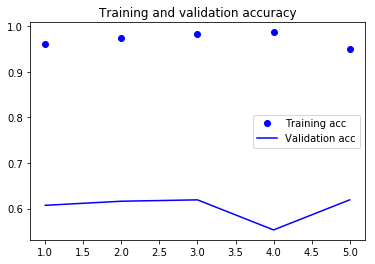

In [9]:
# your code here
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### (d) LSTM [4 points] 

i) [2 point] Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [10]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim =64,input_length=120))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


ii) [2 point] Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy across epochs.

In [13]:
# your code here
lstm_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
history2 = lstm_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=5,
                        batch_size=2048)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 2s 435us/step - loss: 0.9184 - acc: 0.6410 - val_loss: 0.6220 - val_acc: 0.6910
Epoch 2/5
4000/4000 [==============================] - 1s 182us/step - loss: 0.5238 - acc: 0.8468 - val_loss: 0.6095 - val_acc: 0.6940
Epoch 3/5
4000/4000 [==============================] - 1s 184us/step - loss: 0.4957 - acc: 0.8743 - val_loss: 0.6007 - val_acc: 0.7050
Epoch 4/5
4000/4000 [==============================] - 1s 182us/step - loss: 0.4709 - acc: 0.8788 - val_loss: 0.5950 - val_acc: 0.7040
Epoch 5/5
4000/4000 [==============================] - 1s 182us/step - loss: 0.4485 - acc: 0.8790 - val_loss: 0.5910 - val_acc: 0.7040


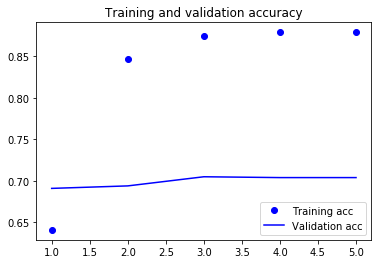

In [14]:
# your code here
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### (e) Evaluation on test data [14 points]

i) [5 points] Using the simple RNN and LSTM models from the previous parts (do *not* retrain these using the full training dataset; it's fine to use the same models you learned from before where technically 20% of the training data were held out as validation data), evaluate their performance on the *test* set (`test.csv`). What are the test set raw accuracies that you get?

In [25]:
# your code here
#preprocessing the test.csv similar to train.csv
#reading data into dataframe
df_test= pd.read_csv("./HW3-data/test.csv",encoding = "ISO-8859-1",header=None)

df_sentiments_test = df_test[[0,5]]
df_sentiments_test = df_test.sample(frac=1).reset_index(drop=True)
df_sentiments_test.shape
#sentiments into list
raw_x_test = df_sentiments_test[5].tolist()
y_test = df_sentiments_test[0].tolist()
len(x_test)
#preprocessing similar to x_train
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(raw_x_test)
seq_test = tokenizer.texts_to_sequences(raw_x_test)

x_test = sequence.pad_sequences(seq_test, maxlen=120)
x_test.shape

(498, 120)

In [26]:
#fitting the models
test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

498/498 [==============================] - 1s 1ms/step
Test accuracy: 0.5000000009575043


In [27]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

498/498 [==============================] - 1s 2ms/step
Test accuracy: 0.5000000009575043


ii) [9 points] In the previous models, we only use the top 5000 tweets. Now train the LSTM-based model using the whole training dataset. Again use 20% of the training dataset as validation. After learning the model, test it on the true test set. What is the test set raw accuracy that you get? How does this test set accuracy compare to the validation accuracy, and to the test set accuracy you got from using only 5000 tweets (or technically 5000\*0.8=4000 tweets to train)?

In [30]:
# your code here
#using complete training data to train our model 
#SimpleRNN model
train_lst = df_sentiments[5].tolist()
y_train = df_sentiments[0].tolist()

#tokenising the full train data
tokenizer.fit_on_texts(train_lst)
seq_full = tokenizer.texts_to_sequences(train_lst)
x_train = sequence.pad_sequences(seq_full, maxlen=120)
x_train.shape

(1600000, 120)

In [36]:
#training LSTM model 
lstm_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
history3 = lstm_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=5,
                        batch_size=2048)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 224s 175us/step - loss: 0.3734 - acc: 0.8321 - val_loss: 0.3894 - val_acc: 0.8240
Epoch 2/5
1280000/1280000 [==============================] - 223s 174us/step - loss: 0.3681 - acc: 0.8351 - val_loss: 0.3874 - val_acc: 0.8250
Epoch 3/5
1280000/1280000 [==============================] - 223s 174us/step - loss: 0.3634 - acc: 0.8377 - val_loss: 0.3875 - val_acc: 0.8248
Epoch 4/5
1280000/1280000 [==============================] - 224s 175us/step - loss: 0.3588 - acc: 0.8403 - val_loss: 0.3897 - val_acc: 0.8246
Epoch 5/5
1280000/1280000 [==============================] - 224s 175us/step - loss: 0.3544 - acc: 0.8428 - val_loss: 0.3927 - val_acc: 0.8232


[0.83209296875, 0.8350828125, 0.8376953125, 0.840259375, 0.842821875]
[0.82399375, 0.8250375, 0.824828125, 0.824584375, 0.823153125]


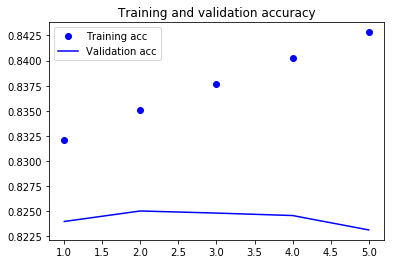

In [42]:
#plotting the validation accuracy and training accuracy
acc = history3.history['acc']
print(acc)
val_acc = history3.history['val_acc']
print(val_acc)
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [44]:
#predicting on test data 
full_test_loss, full_test_acc = lstm_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

498/498 [==============================] - 1s 3ms/step
Test accuracy: 0.5000000009575043


What is the test set raw accuracy that you get? How does this test set accuracy compare to the validation accuracy, and to the test set accuracy you got from using only 5000 tweets (or technically 5000\*0.8=4000 tweets to train)?

***The test set raw accuracy is approximately 50%. The validation set accuracy is approximately 82%. The validation set has very high accuracy compared to test set. The test set accuracy with 5000 tweets is 50% which is equal to the full test set accuracy.***